In [1]:
## importing packages
import numpy as np
import pandas as pd

In [2]:
## defining constants
PATH_STATION_HOUR = "./station_hour.csv"
PATH_STATION_DAY = "./station_day.csv"
PATH_CITY_HOUR = "./city_hour.csv"
PATH_CITY_DAY = "./city_day.csv"
PATH_STATIONS = "./stations.csv"

STATIONS = ["KL007", "KL008"]

In [3]:
## importing data and subsetting the station
df = pd.read_csv(PATH_STATION_HOUR, parse_dates = ["Datetime"])
stations = pd.read_csv(PATH_STATIONS)

df = df.merge(stations, on = "StationId")

df = df[df.StationId.isin(STATIONS)]
df.sort_values(["StationId", "Datetime"], inplace = True)
df["Date"] = df.Datetime.dt.date.astype(str)
df.Datetime = df.Datetime.astype(str)

Formula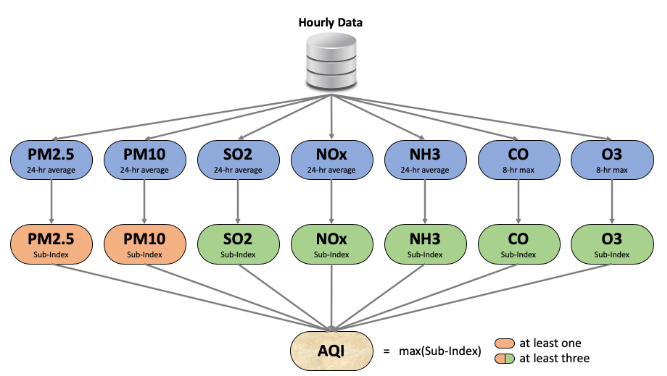

The AQI calculation uses 7 measures: PM2.5, PM10, SO2, NOx, NH3, CO and O3.
For PM2.5, PM10, SO2, NOx and NH3 the average value in last 24-hrs is used with the condition of having at least 16 values.
For CO and O3 the maximum value in last 8-hrs is used.
Each measure is converted into a Sub-Index based on pre-defined groups.
Sometimes measures are not available due to lack of measuring or lack of required data points.
Final AQI is the maximum Sub-Index with the condition that at least one of PM2.5 and PM10 should be available and at least three out of the seven should be available.

In [4]:
df["PM10_24hr_avg"] = df.groupby("StationId")["PM10"].rolling(window = 24, min_periods = 16).mean().values
df["PM2.5_24hr_avg"] = df.groupby("StationId")["PM2.5"].rolling(window = 24, min_periods = 16).mean().values
df["SO2_24hr_avg"] = df.groupby("StationId")["SO2"].rolling(window = 24, min_periods = 16).mean().values
df["NOx_24hr_avg"] = df.groupby("StationId")["NOx"].rolling(window = 24, min_periods = 16).mean().values
df["NH3_24hr_avg"] = df.groupby("StationId")["NH3"].rolling(window = 24, min_periods = 16).mean().values
df["CO_8hr_max"] = df.groupby("StationId")["CO"].rolling(window = 8, min_periods = 1).max().values
df["O3_8hr_max"] = df.groupby("StationId")["O3"].rolling(window = 8, min_periods = 1).max().values

In [5]:
## PM2.5 Sub-Index calculation
def get_PM25_subindex(x):
    if x <= 30:
        return x * 50 / 30
    elif x <= 60:
        return 50 + (x - 30) * 50 / 30
    elif x <= 90:
        return 100 + (x - 60) * 100 / 30
    elif x <= 120:
        return 200 + (x - 90) * 100 / 30
    elif x <= 250:
        return 300 + (x - 120) * 100 / 130
    elif x > 250:
        return 400 + (x - 250) * 100 / 130
    else:
        return 0

df["PM2.5_SubIndex"] = df["PM2.5_24hr_avg"].apply(lambda x: get_PM25_subindex(x))

In [6]:
## PM10 Sub-Index calculation
def get_PM10_subindex(x):
    if x <= 50:
        return x
    elif x <= 100:
        return x
    elif x <= 250:
        return 100 + (x - 100) * 100 / 150
    elif x <= 350:
        return 200 + (x - 250)
    elif x <= 430:
        return 300 + (x - 350) * 100 / 80
    elif x > 430:
        return 400 + (x - 430) * 100 / 80
    else:
        return 0

df["PM10_SubIndex"] = df["PM10_24hr_avg"].apply(lambda x: get_PM10_subindex(x))

In [7]:
## SO2 Sub-Index calculation
def get_SO2_subindex(x):
    if x <= 40:
        return x * 50 / 40
    elif x <= 80:
        return 50 + (x - 40) * 50 / 40
    elif x <= 380:
        return 100 + (x - 80) * 100 / 300
    elif x <= 800:
        return 200 + (x - 380) * 100 / 420
    elif x <= 1600:
        return 300 + (x - 800) * 100 / 800
    elif x > 1600:
        return 400 + (x - 1600) * 100 / 800
    else:
        return 0

df["SO2_SubIndex"] = df["SO2_24hr_avg"].apply(lambda x: get_SO2_subindex(x))

In [8]:
## NOx Sub-Index calculation
def get_NOx_subindex(x):
    if x <= 40:
        return x * 50 / 40
    elif x <= 80:
        return 50 + (x - 40) * 50 / 40
    elif x <= 180:
        return 100 + (x - 80) * 100 / 100
    elif x <= 280:
        return 200 + (x - 180) * 100 / 100
    elif x <= 400:
        return 300 + (x - 280) * 100 / 120
    elif x > 400:
        return 400 + (x - 400) * 100 / 120
    else:
        return 0

df["NOx_SubIndex"] = df["NOx_24hr_avg"].apply(lambda x: get_NOx_subindex(x))

In [9]:
## NH3 Sub-Index calculation
def get_NH3_subindex(x):
    if x <= 200:
        return x * 50 / 200
    elif x <= 400:
        return 50 + (x - 200) * 50 / 200
    elif x <= 800:
        return 100 + (x - 400) * 100 / 400
    elif x <= 1200:
        return 200 + (x - 800) * 100 / 400
    elif x <= 1800:
        return 300 + (x - 1200) * 100 / 600
    elif x > 1800:
        return 400 + (x - 1800) * 100 / 600
    else:
        return 0

df["NH3_SubIndex"] = df["NH3_24hr_avg"].apply(lambda x: get_NH3_subindex(x))

In [10]:
## CO Sub-Index calculation
def get_CO_subindex(x):
    if x <= 1:
        return x * 50 / 1
    elif x <= 2:
        return 50 + (x - 1) * 50 / 1
    elif x <= 10:
        return 100 + (x - 2) * 100 / 8
    elif x <= 17:
        return 200 + (x - 10) * 100 / 7
    elif x <= 34:
        return 300 + (x - 17) * 100 / 17
    elif x > 34:
        return 400 + (x - 34) * 100 / 17
    else:
        return 0

df["CO_SubIndex"] = df["CO_8hr_max"].apply(lambda x: get_CO_subindex(x))

In [11]:
## O3 Sub-Index calculation
def get_O3_subindex(x):
    if x <= 50:
        return x * 50 / 50
    elif x <= 100:
        return 50 + (x - 50) * 50 / 50
    elif x <= 168:
        return 100 + (x - 100) * 100 / 68
    elif x <= 208:
        return 200 + (x - 168) * 100 / 40
    elif x <= 748:
        return 300 + (x - 208) * 100 / 539
    elif x > 748:
        return 400 + (x - 400) * 100 / 539
    else:
        return 0

df["O3_SubIndex"] = df["O3_8hr_max"].apply(lambda x: get_O3_subindex(x))

AQI
The final AQI is the maximum Sub-Index among the available sub-indices with the condition that at least one of PM2.5 and PM10 should be available and at least three out of the seven should be available.

There is no theoretical upper value of AQI but its rare to find values over 1000.

The pre-defined buckets of AQI are as follows:

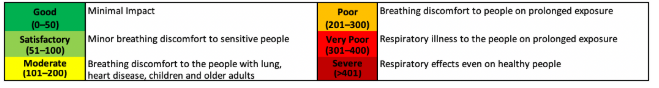

In [12]:
## AQI bucketing
def get_AQI_bucket(x):
    if x <= 50:
        return "Good"
    elif x <= 100:
        return "Satisfactory"
    elif x <= 200:
        return "Moderate"
    elif x <= 300:
        return "Poor"
    elif x <= 400:
        return "Very Poor"
    elif x > 400:
        return "Severe"
    else:
        return np.NaN

df["Checks"] = (df["PM2.5_SubIndex"] > 0).astype(int) + \
                (df["PM10_SubIndex"] > 0).astype(int) + \
                (df["SO2_SubIndex"] > 0).astype(int) + \
                (df["NOx_SubIndex"] > 0).astype(int) + \
                (df["NH3_SubIndex"] > 0).astype(int) + \
                (df["CO_SubIndex"] > 0).astype(int) + \
                (df["O3_SubIndex"] > 0).astype(int)

df["AQI_calculated"] = round(df[["PM2.5_SubIndex", "PM10_SubIndex", "SO2_SubIndex", "NOx_SubIndex",
                                 "NH3_SubIndex", "CO_SubIndex", "O3_SubIndex"]].max(axis = 1))
df.loc[df["PM2.5_SubIndex"] + df["PM10_SubIndex"] <= 0, "AQI_calculated"] = np.NaN
df.loc[df.Checks < 3, "AQI_calculated"] = np.NaN

df["AQI_bucket_calculated"] = df["AQI_calculated"].apply(lambda x: get_AQI_bucket(x))
df[~df.AQI_calculated.isna()].head(13)

,StationId,Datetime,PM2.5,PM10,NO,NO2,NOx,NH3,CO,SO2,O3,Benzene,Toluene,Xylene,AQI,AQI_Bucket,StationName,City,State,Status,Date,PM10_24hr_avg,PM2.5_24hr_avg,SO2_24hr_avg,NOx_24hr_avg,NH3_24hr_avg,CO_8hr_max,O3_8hr_max,PM2.5_SubIndex,PM10_SubIndex,SO2_SubIndex,NOx_SubIndex,NH3_SubIndex,CO_SubIndex,O3_SubIndex,Checks,AQI_calculated,AQI_bucket_calculated
1539078,KL007,2020-02-14 08:00:00,35.81,51.71,22.90,27.43,52.33,22.90,0.71,1.14,15.75,NaN,NaN,NaN,66.0,Satisfactory,"Kariavattom, Thiruvananthapuram - Kerala PCB",Thiruvananthapuram,Kerala,Active,2020-02-14,NaN,39.650625,1.880000,34.733750,8.284375,0.71,31.95,66.084375,0.000000,2.350000,43.417187,2.071094,35.5,31.950000,6,66.0,Satisfactory
1539079,KL007,2020-02-14 09:00:00,38.47,58.54,48.09,51.82,101.90,48.09,1.46,1.65,16.40,NaN,NaN,NaN,73.0,Satisfactory,"Kariavattom, Thiruvananthapuram - Kerala PCB",Thiruvananthapuram,Kerala,Active,2020-02-14,60.143125,39.581176,1.866471,38.684706,10.625882,1.46,31.95,65.968627,60.143125,2.333088,48.355882,2.656471,73.0,31.950000,7,73.0,Satisfactory
1539080,KL007,2020-02-14 10:00:00,47.94,76.12,12.11,34.90,49.01,12.11,0.81,1.77,55.36,NaN,NaN,NaN,73.0,Satisfactory,"Kariavattom, Thiruvananthapuram - Kerala PCB",Thiruvananthapuram,Kerala,Active,2020-02-14,61.082941,40.045556,1.861111,39.258333,10.708333,1.46,55.36,66.742593,61.082941,2.326389,49.072917,2.677083,73.0,55.360000,7,73.0,Satisfactory
1539081,KL007,2020-02-14 11:00:00,53.81,79.47,5.82,27.12,34.94,5.82,0.48,1.97,81.29,NaN,NaN,NaN,81.0,Satisfactory,"Kariavattom, Thiruvananthapuram - Kerala PCB",Thiruvananthapuram,Kerala,Active,2020-02-14,62.104444,40.770000,1.866842,39.031053,10.451053,1.46,81.29,67.950000,62.104444,2.333553,48.788816,2.612763,73.0,81.290000,7,81.0,Satisfactory
1539082,KL007,2020-02-14 12:00:00,46.91,61.87,5.85,30.14,38.00,5.85,0.42,2.11,87.83,NaN,NaN,NaN,88.0,Satisfactory,"Kariavattom, Thiruvananthapuram - Kerala PCB",Thiruvananthapuram,Kerala,Active,2020-02-14,62.092105,41.077000,1.879000,38.979500,10.221000,1.46,87.83,68.461667,62.092105,2.348750,48.724375,2.555250,73.0,87.830000,7,88.0,Satisfactory
1539083,KL007,2020-02-14 13:00:00,45.43,72.93,4.13,18.97,25.11,4.13,0.27,2.38,100.33,NaN,NaN,NaN,100.0,Satisfactory,"Kariavattom, Thiruvananthapuram - Kerala PCB",Thiruvananthapuram,Kerala,Active,2020-02-14,62.634000,41.284286,1.902857,38.319048,9.930952,1.46,100.33,68.807143,62.634000,2.378571,47.898810,2.482738,73.0,100.485294,7,100.0,Satisfactory
1539084,KL007,2020-02-14 14:00:00,42.52,66.83,6.44,28.01,36.46,6.44,0.39,2.65,93.28,NaN,NaN,NaN,100.0,Satisfactory,"Kariavattom, Thiruvananthapuram - Kerala PCB",Thiruvananthapuram,Kerala,Active,2020-02-14,62.833810,41.340455,1.936818,38.234545,9.772273,1.46,100.33,68.900758,62.833810,2.421023,47.793182,2.443068,73.0,100.485294,7,100.0,Satisfactory
1539085,KL007,2020-02-14 15:00:00,38.99,66.50,5.58,25.85,33.42,5.58,0.33,2.48,103.32,NaN,NaN,NaN,105.0,Moderate,"Kariavattom, Thiruvananthapuram - Kerala PCB",Thiruvananthapuram,Kerala,Active,2020-02-14,63.000455,41.238261,1.960435,38.025217,9.590000,1.46,103.32,68.730435,63.000455,2.450543,47.531522,2.397500,73.0,104.882353,7,105.0,Moderate
1539086,KL007,2020-02-14 16:00:00,35.14,85.24,5.76,28.52,36.28,5.76,0.32,2.48,98.70,NaN,NaN,NaN,105.0,Moderate,"Kariavattom, Thiruvananthapuram - Kerala PCB",Thiruvananthapuram,Kerala,Active,2020-02-14,63.967391,40.984167,1.982083,37.952500,9.430417,1.46,103.32,68.306944,63.967391,2.477604,47.440625,2.357604,73.0,104.882353,7,105.0,Moderate
1539087,KL007,2020-02-14 17:00:00,43.85,74.63,4.31,19.27,25.59,4.31,0.19,2.79,97.52,NaN,NaN,NaN,105.0,Moderate,"Kariavattom, Thiruvananthapuram - Kerala PCB",Thiruvananthapuram,Kerala,Active,2020-02-14,64.411667,41.272083,1.992083,37.926667,9.427917,0.81,103.32,68.786806,64.411667,2.490104,47.408333,2.356979,40.5,104.882353,7,105.0,Moderate


In [13]:
df[~df.AQI_calculated.isna()].AQI_bucket_calculated.value_counts()

Satisfactory    16457
Moderate         4487
Good             3801
Poor              121
Name: AQI_bucket_calculated, dtype: int64

In [14]:
df_station_hour = df
df_station_day = pd.read_csv(PATH_STATION_DAY)

df_station_day = df_station_day.merge(df.groupby(["StationId", "Date"])["AQI_calculated"].mean().reset_index(), on = ["StationId", "Date"])
df_station_day.AQI_calculated = round(df_station_day.AQI_calculated)

In [15]:
df_city_hour = pd.read_csv(PATH_CITY_HOUR)
df_city_day = pd.read_csv(PATH_CITY_DAY)

df_city_hour["Date"] = pd.to_datetime(df_city_hour.Datetime).dt.date.astype(str)

df_city_hour = df_city_hour.merge(df.groupby(["City", "Datetime"])["AQI_calculated"].mean().reset_index(), on = ["City", "Datetime"])
df_city_hour.AQI_calculated = round(df_city_hour.AQI_calculated)

df_city_day = df_city_day.merge(df_city_hour.groupby(["City", "Date"])["AQI_calculated"].mean().reset_index(), on = ["City", "Date"])
df_city_day.AQI_calculated = round(df_city_day.AQI_calculated)

In [16]:
df_check_station_hour = df_station_hour[["AQI", "AQI_calculated"]].dropna()
df_check_station_day = df_station_day[["AQI", "AQI_calculated"]].dropna()
df_check_city_hour = df_city_hour[["AQI", "AQI_calculated"]].dropna()
df_check_city_day = df_city_day[["AQI", "AQI_calculated"]].dropna()

print("Station + Hour")
print("Rows: ", df_check_station_hour.shape[0])
print("Matched AQI: ", (df_check_station_hour.AQI == df_check_station_hour.AQI_calculated).sum())
print("% Match: ", (df_check_station_hour.AQI == df_check_station_hour.AQI_calculated).sum() * 100 / df_check_station_hour.shape[0])
print("\n")
print("Station + Day")
print("Rows: ", df_check_station_day.shape[0])
print("Matched AQI: ", (df_check_station_day.AQI == df_check_station_day.AQI_calculated).sum())
print("% Match: ", (df_check_station_day.AQI == df_check_station_day.AQI_calculated).sum() * 100 / df_check_station_day.shape[0])
print("\n")
print("City + Hour")
print("Rows: ", df_check_city_hour.shape[0])
print("Matched AQI: ", (df_check_city_hour.AQI == df_check_city_hour.AQI_calculated).sum())
print("% Match: ", (df_check_city_hour.AQI == df_check_city_hour.AQI_calculated).sum() * 100 / df_check_city_hour.shape[0])
print("\n")
print("City + Day")
print("Rows: ", df_check_city_day.shape[0])
print("Matched AQI: ", (df_check_city_day.AQI == df_check_city_day.AQI_calculated).sum())
print("% Match: ", (df_check_city_day.AQI == df_check_city_day.AQI_calculated).sum() * 100 / df_check_city_day.shape[0])

Station + Hour
Rows:  24866
Matched AQI:  24866
% Match:  100.0


Station + Day
Rows:  1062
Matched AQI:  1062
% Match:  100.0


City + Hour
Rows:  23297
Matched AQI:  23297
% Match:  100.0


City + Day
Rows:  991
Matched AQI:  991
% Match:  100.0
